In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read from training & ethereum datasets

In [2]:
# source 1: https://ethereumprice.org/history/
# source 2: https://www.nasdaq.com/market-activity/cryptocurrency/eth/historical

PATH = 'data/'
FILE_train = 'XYtr.csv'
#FILE_eth = 'HistoricalData_1636140037191.csv'
FILE_eth = '2019-01-01_2021-11-04_ethereumprice_org.csv'

train = pd.read_csv(PATH + FILE_train, usecols=[2,9])
eth = pd.read_csv(PATH + FILE_eth, usecols=[0,1])

In [3]:
train

,cdate,total
0,2019-04-26,0.055
1,2020-10-26,75.000
2,2019-04-26,0.158
3,2019-04-26,1.990
4,2019-04-26,1.000
...,...,...
6909,2020-11-27,0.550
6910,2019-04-26,0.100
6911,2019-05-08,0.966
6912,2021-06-12,0.170


In [4]:
eth

,timestamp,open
0,1635984000,4605.600000
1,1635897600,4598.000000
2,1635811200,4324.210000
3,1635811140,4325.548484
4,1635724800,4295.350000
...,...,...
1193,1546646400,156.230000
1194,1546560000,156.040000
1195,1546473600,149.440000
1196,1546387200,156.570000


### Format dates for train & ethereum datasets

In [5]:
tr_date = train['cdate']
train['cdate'] = pd.to_datetime(tr_date).values.astype(np.float64)/8.64e+13

In [6]:
# https://datascience.stackexchange.com/questions/14645/convert-a-pandas-column-of-int-to-timestamp-datatype
# https://stackoverflow.com/questions/20480897/pandas-add-one-day-to-column
eth['timestamp'] = pd.to_datetime(eth['timestamp'], unit='s') - pd.DateOffset(1)
# https://stackoverflow.com/questions/29310116/removing-time-from-datetime-variable-in-pandas
eth['timestamp'] = pd.to_datetime(eth['timestamp']).dt.date
dates = eth['timestamp']
eth['timestamp'] = pd.to_datetime(dates).values.astype(np.float64)/8.64e+13
eth.rename(columns={'timestamp':'cdate'}, inplace=True)

In [7]:
print(train.info())
print()
print(eth.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cdate   6914 non-null   float64
 1   total   6914 non-null   float64
dtypes: float64(2)
memory usage: 108.2 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cdate   1198 non-null   float64
 1   open    1198 non-null   float64
dtypes: float64(2)
memory usage: 18.8 KB
None


In [8]:
# https://stackoverflow.com/questions/60294634/select-first-row-when-there-are-multiple-rows-with-repeated-values-in-a-column
eth.drop_duplicates(subset = ['cdate'], keep = 'first', inplace = True) 

### Merge ethereum data to train data by dates

In [9]:
# https://towardsdatascience.com/left-join-with-pandas-data-frames-in-python-c29c85089ba4
train = train.merge(eth, on = 'cdate', how = 'left')

In [10]:
train

,cdate,total,open
0,18012.0,0.055,157.995247
1,18561.0,75.000,403.917828
2,18012.0,0.158,157.995247
3,18012.0,1.990,157.995247
4,18012.0,1.000,157.995247
...,...,...,...
6909,18593.0,0.550,519.371790
6910,18012.0,0.100,157.995247
6911,18024.0,0.966,171.533093
6912,18790.0,0.170,2509.820000


### Check feature distributions

<AxesSubplot:xlabel='total', ylabel='Density'>

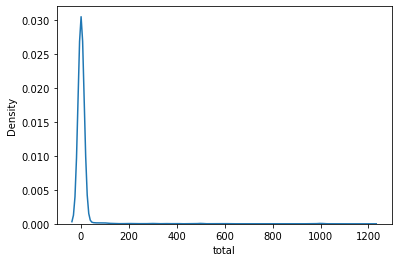

In [11]:
# https://rstudio-pubs-static.s3.amazonaws.com/212263_df6931d8662f42efb3b69dd072d6212f.html
sns.kdeplot(train['total'])

<AxesSubplot:xlabel='open', ylabel='Density'>

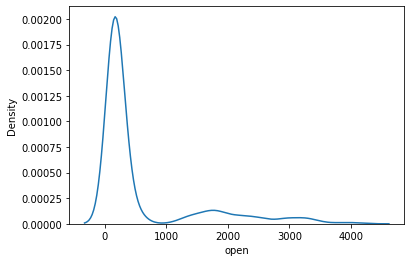

In [12]:
sns.kdeplot(train['open'])

#### Handle right-skewed data 

In [13]:
# Apply log() and square-root() functions to features
train["sqrt-total"] = np.sqrt(train['total'])
train["log-open"] = np.log(train['open'])
train["sqrt-open"] = np.sqrt(train['open'])

In [14]:
train

,cdate,total,open,sqrt-total,log-open,sqrt-open
0,18012.0,0.055,157.995247,0.234521,5.062565,12.569616
1,18561.0,75.000,403.917828,8.660254,6.001211,20.097707
2,18012.0,0.158,157.995247,0.397492,5.062565,12.569616
3,18012.0,1.990,157.995247,1.410674,5.062565,12.569616
4,18012.0,1.000,157.995247,1.000000,5.062565,12.569616
...,...,...,...,...,...,...
6909,18593.0,0.550,519.371790,0.741620,6.252620,22.789730
6910,18012.0,0.100,157.995247,0.316228,5.062565,12.569616
6911,18024.0,0.966,171.533093,0.982853,5.144776,13.097064
6912,18790.0,0.170,2509.820000,0.412311,7.827966,50.098104


### Spearman Correlations

In [15]:
train['total'].corr(train['open'], method = "spearman")

0.006986136472472196

In [16]:
train['total'].corr(train['log-open'], method = "spearman")

0.006986136472472196

In [17]:
train['total'].corr(train['sqrt-open'], method = "spearman")

0.006986136472472196

In [18]:
train['sqrt-total'].corr(train['open'], method = "spearman")

0.006986136472472196

In [19]:
train['sqrt-total'].corr(train['log-open'], method = "spearman")

0.006986136472472196

In [20]:
train['sqrt-total'].corr(train['sqrt-open'], method = "spearman")

0.006986136472472196

#### visualizations

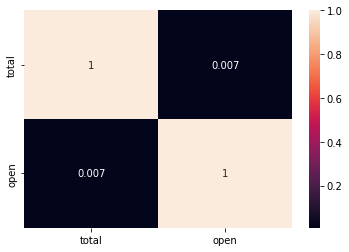

In [21]:
# https://stackoverflow.com/questions/62201732/how-to-scatter-plot-or-heatmap-spearmans-correlation-in-python
# https://cmdlinetips.com/2019/08/how-to-compute-pearson-and-spearman-correlation-in-python/
corr = train[['total', 'open']].corr(method = 'spearman')
sns.heatmap(corr, annot = True)
plt.show()

<AxesSubplot:xlabel='total', ylabel='open'>

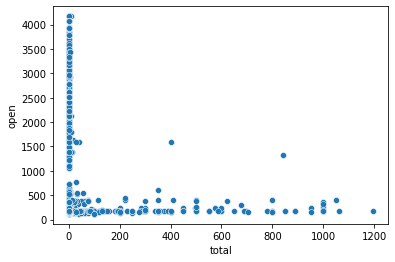

In [22]:
sns.scatterplot(data=train[['total', 'open']], x="total", y="open")

### Summary - Given the low correlative value (0.007), the price of ethereum at NFT creation date does not affect auction price